These experiments are carried out on the [CSE-CIC-IDS2018](https://www.unb.ca/cic/datasets/ids-2018.html) data set.

To download it, install the [AWS CLI](https://aws.amazon.com/cli/), then,

#### Run: aws s3 sync --no-sign-request --region ca-central-1 "s3://cse-cic-ids2018/" Desktop

This will download the entire data set to your Desktop folder.

Then install CICFlowMeter for feature extraction,

#### Run: pip install cicflowmeter (Requires python>=3.7.0)

Then, to convert pcap file to python using cicflowmeter,

#### Run: cicflowmeter -f example.pcap -c flows.csv

Here we will demonstrate using the data collected on 23-02-2018, 22-02-2018,21-02-2018, 15-02-2018 and 14-02-2018

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from collections import Counter
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import ExtraTreesClassifier, IsolationForest
from sklearn.metrics import mean_absolute_error
from sklearn import set_config
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn import manifold
from imblearn.under_sampling import RandomUnderSampler
from itertools import compress

from xgboost import XGBClassifier

%matplotlib inline
np.random.seed(42)
pd.set_option("display.max_columns", None)
set_config(display='diagram') #interactive diagram

# Preprocessing

In [2]:
ids_datatypes = {
    'Dst Port': np.int32,
    'Protocol': np.int8,
    'Timestamp': object,
    'Flow Duration': np.int64,
    'Tot Fwd Pkts': np.int16,
    'Tot Bwd Pkts': np.int16,
    'TotLen Fwd Pkts': np.int32,
    'TotLen Bwd Pkts': np.int32,
    'Fwd Pkt Len Max': np.int32,
    'Fwd Pkt Len Min': np.int32,
    'Fwd Pkt Len Mean': np.float64,
    'Fwd Pkt Len Std': np.float64,
    'Bwd Pkt Len Max': np.int16,
    'Bwd Pkt Len Min': np.int16,
    'Bwd Pkt Len Mean': np.float64,
    'Bwd Pkt Len Std': np.float64,
    'Flow Byts/s': np.float64,
    'Flow Pkts/s': np.float64,
    'Flow IAT Mean': np.float64,
    'Flow IAT Std': np.float64,
    'Flow IAT Max': np.int64,
    'Flow IAT Min': np.int32,
    'Fwd IAT Tot': np.int32,
    'Fwd IAT Mean': np.float32,
    'Fwd IAT Std': np.float64,
    'Fwd IAT Max': np.int32, 
    'Fwd IAT Min': np.int32,
    'Bwd IAT Tot': np.int32,
    'Bwd IAT Mean': np.float64,
    'Bwd IAT Std': np.float64,
    'Bwd IAT Max': np.int64,
    'Bwd IAT Min': np.int64,
    'Fwd PSH Flags': np.int8,
    'Bwd PSH Flags': np.int8,
    'Fwd URG Flags': np.int8,
    'Bwd URG Flags': np.int8,
    'Fwd Header Len': np.int32,
    'Bwd Header Len': np.int32,
    'Fwd Pkts/s' : np.float64,
    'Bwd Pkts/s': np.float64,
    'Pkt Len Min': np.int16,
    'Pkt Len Max': np.int32,
    'Pkt Len Mean': np.float64,
    'Pkt Len Std': np.float64,
    'Pkt Len Var': np.float64,
    'FIN Flag Cnt': np.int8,
    'SYN Flag Cnt': np.int8,
    'RST Flag Cnt': np.int8,
    'PSH Flag Cnt': np.int8,
    'ACK Flag Cnt': np.int8,
    'URG Flag Cnt': np.int8,
    'CWE Flag Count': np.int8,
    'ECE Flag Cnt': np.int8,
    'Down/Up Ratio': np.int64,
    'Pkt Size Avg': np.float32,
    'Fwd Seg Size Avg': np.float32,
    'Bwd Seg Size Avg': np.float32,
    'Fwd Byts/b Avg': np.int8,
    'Fwd Pkts/b Avg': np.int8,
    'Fwd Blk Rate Avg': np.int8,
    'Bwd Byts/b Avg': np.int8,
    'Bwd Pkts/b Avg': np.int8,
    'Bwd Blk Rate Avg': np.int8,
    'Subflow Fwd Pkts': np.int16,
    'Subflow Fwd Byts': np.int32,
    'Subflow Bwd Pkts': np.int16,
    'Subflow Bwd Byts': np.int32,
    'Init Fwd Win Byts': np.int32, 
    'Init Bwd Win Byts': np.int32,
    'Fwd Act Data Pkts': np.int16,
    'Fwd Seg Size Min': np.int8,
    'Active Mean': np.float64,
    'Active Std': np.float64,
    'Active Max': np.int32,
    'Active Min': np.int32,
    'Idle Mean': np.float64,
    'Idle Std': np.float64,
    'Idle Max': np.int64,
    'Idle Min': np.int64,
    'Label': object
}
used_cols = (ids_datatypes.keys())

In [3]:
d1 = pd.read_csv('../../../../../Desktop/CSE-CIC-IDS2018/23-02-2018.csv',
                 dtype=ids_datatypes, usecols=used_cols, low_memory=False)

d2 = pd.read_csv('../../../../../Desktop/CSE-CIC-IDS2018/22-02-2018.csv',
                 dtype=ids_datatypes, usecols=used_cols, low_memory=False)

d3 = pd.read_csv('../../../../../Desktop/CSE-CIC-IDS2018/21-02-2018.csv',
                 dtype=ids_datatypes, usecols=used_cols, low_memory=False)

d4 = pd.read_csv('../../../../../Desktop/CSE-CIC-IDS2018/15-02-2018.csv',
                 dtype=ids_datatypes, usecols=used_cols, low_memory=False)

d5 = pd.read_csv('../../../../../Desktop/CSE-CIC-IDS2018/14-02-2018.csv',
                 dtype=ids_datatypes, usecols=used_cols, low_memory=False)

In [4]:
dfs = [
    d1, 
    d2,
    d3,
    d4, 
    d5
]
ds = pd.concat(dfs)
ds = ds.sample(frac=1).reset_index(drop=True)
del dfs

In [5]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5242875 entries, 0 to 5242874
Data columns (total 80 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           int32  
 1   Protocol           int8   
 2   Timestamp          object 
 3   Flow Duration      int64  
 4   Tot Fwd Pkts       int16  
 5   Tot Bwd Pkts       int16  
 6   TotLen Fwd Pkts    int32  
 7   TotLen Bwd Pkts    int32  
 8   Fwd Pkt Len Max    int32  
 9   Fwd Pkt Len Min    int32  
 10  Fwd Pkt Len Mean   float64
 11  Fwd Pkt Len Std    float64
 12  Bwd Pkt Len Max    int16  
 13  Bwd Pkt Len Min    int16  
 14  Bwd Pkt Len Mean   float64
 15  Bwd Pkt Len Std    float64
 16  Flow Byts/s        float64
 17  Flow Pkts/s        float64
 18  Flow IAT Mean      float64
 19  Flow IAT Std       float64
 20  Flow IAT Max       int64  
 21  Flow IAT Min       int32  
 22  Fwd IAT Tot        int32  
 23  Fwd IAT Mean       float32
 24  Fwd IAT Std        float64
 25  Fwd IAT Max       

In [6]:
ds.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,53,17,22/02/2018 11:18:27,5688205,2,2,82,242,51,31,41.000000,14.142136,147,95,121.000000,36.769553,56.959972,7.032095e-01,1.896068e+06,3.283319e+06,5687318,430,5687748,5.687748e+06,0.000000e+00,5687748,5687748,5687775,5.687775e+06,0.000000e+00,5687775,5687775,0,0,0,0,16,16,0.351605,0.351605,31,147,75.000000,46.561787,2168.000000,0,0,0,0,0,0,0,0,1,93.750000,41.000000,121.000000,0,0,0,0,0,0,2,82,2,242,-1,-1,1,8,430.000000,0.000000,430,430,5.687318e+06,0.000000,5687318,5687318,Benign
1,80,6,22/02/2018 08:29:33,39398,4,10,249,10515,249,0,62.250000,124.500000,1460,0,1051.500000,662.629652,273211.838164,3.553480e+02,3.030615e+03,7.208370e+03,19311,0,39398,1.313267e+04,1.131369e+04,19983,74,20053,2.228111e+03,6.416130e+03,19326,0,0,0,0,0,92,212,101.527996,253.819991,0,1460,717.600000,724.370643,524712.828571,0,0,0,1,0,0,0,0,2,768.857117,62.250000,1051.500000,0,0,0,0,0,0,4,249,10,10515,8192,237,1,20,0.000000,0.000000,0,0,0.000000e+00,0.000000,0,0,Benign
2,21,6,14/02/2018 11:26:59,1,1,1,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,2.000000e+06,1.000000e+00,0.000000e+00,1,1,0,0.000000e+00,0.000000e+00,0,0,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,40,20,1000000.000000,1000000.000000,0,0,0.000000,0.000000,0.000000,0,0,0,1,0,0,0,0,1,0.000000,0.000000,0.000000,0,0,0,0,0,0,1,0,1,0,26883,0,0,40,0.000000,0.000000,0,0,0.000000e+00,0.000000,0,0,FTP-BruteForce
3,443,6,23/02/2018 04:29:24,119935186,14,22,8,4821,1,0,0.571429,0.513553,1225,0,219.136364,418.442383,40.263414,3.001621e-01,3.426720e+06,4.779943e+06,10000767,1,119935186,9.225784e+06,2.753656e+06,10046608,62892,119881652,5.708650e+06,5.063701e+06,10040039,1,0,0,0,0,280,536,0.116730,0.183432,0,1225,130.513514,337.605508,113977.478979,0,0,0,0,1,0,0,0,1,134.138885,0.571429,219.136368,0,0,0,0,0,0,14,8,22,4821,4779,5565,8,20,40998.833333,16079.204457,70664,30272,9.948806e+06,62539.710158,10000767,9771255,Benign
4,53,17,15/02/2018 11:33:12,1589,1,1,40,134,40,40,40.000000,0.000000,134,134,134.000000,0.000000,109502.831970,1.258653e+03,1.589000e+03,0.000000e+00,1589,1589,0,0.000000e+00,0.000000e+00,0,0,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,8,8,629.326621,629.326621,40,134,71.333333,54.270925,2945.333333,0,0,0,0,0,0,0,0,1,107.000000,40.000000,134.000000,0,0,0,0,0,0,1,40,1,134,-1,-1,0,8,0.000000,0.000000,0,0,0.000000e+00,0.000000,0,0,Benign


In [7]:
# check for NaN values 
ds.isna().sum().sum()

14521

In [8]:
# drop NaN values
ds = ds.dropna()

# recheck
ds.isna().sum().sum()

0

In [9]:
# check for values approaching infinity
ds = ds.replace([np.inf, -np.inf], np.nan)
ds.isna().sum().sum()

17296

In [10]:
# drop those values
ds = ds.dropna()

# recheck
ds.isna().sum().sum()

0

In [11]:
Counter(ds.Label)

Counter({'Benign': 4097595,
         'FTP-BruteForce': 193354,
         'SSH-Bruteforce': 187589,
         'DDOS attack-HOIC': 686012,
         'DoS attacks-GoldenEye': 41508,
         'DoS attacks-Slowloris': 10990,
         'DDOS attack-LOIC-UDP': 1730,
         'Brute Force -Web': 611,
         'Brute Force -XSS': 230,
         'SQL Injection': 87})

In [12]:
# here, we encode labels for binary classification
# for multiclass classification,
# you can edit the labels with the desired class number

label_dict = {
    'Benign': 0,
    'DDOS attack-HOIC': 1,
    'FTP-BruteForce': 1,
    'DoS attacks-GoldenEye': 1,
    'SSH-Bruteforce': 1,
    'DoS attacks-Slowloris': 1,
    'Brute Force -XSS': 1,
    'SQL Injection': 1,
    'DDOS attack-LOIC-UDP': 1,
    'Brute Force -Web': 1
}
ds['Label'] = [label_dict[item] for item in ds['Label']]

/opt/anaconda3/envs/py_36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Label', ylabel='count'>

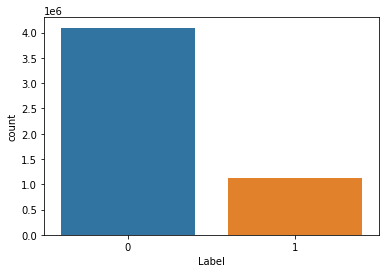

In [13]:
sns.countplot(ds.Label)

# Model building

/opt/anaconda3/envs/py_36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Label', ylabel='count'>

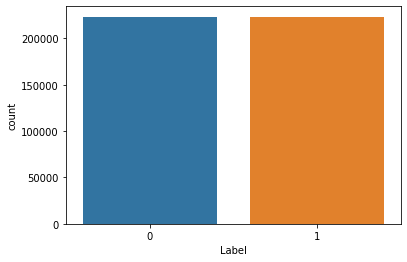

In [14]:
ds = ds.sample(frac=0.2, replace=True, random_state=42).reset_index(drop=True)

y = ds.Label
X = ds.drop(["Label", "Timestamp"], axis=1)

# Here, we randomly select 20% of the data set and undersample it
# **omit the first line of this cell and the line below if you want to run on the entire data set**

X, y = RandomUnderSampler().fit_resample(X, y)

sns.countplot(y)

In [15]:
def append_avgs(dict):
    avgs = []
    stds = []
    for i in dict:
        avg = np.average(dict[i])
        std = np.std(dict[i])
        avgs.append(avg)
        stds.append(std)
    df = pd.DataFrame(dict)
    df.loc[5] = avgs
    df.loc[6] = stds
    return df

In [16]:
# define column selector for feature scaling
numerical_columns_selector = make_column_selector(dtype_exclude=object)
numerical_columns = numerical_columns_selector(X)

#categorical_columns_selector = make_column_selector(dtype_include=object)
#categorical_columns = categorical_columns_selector(X)


#define scaler
sc = StandardScaler()

# Scale numerical features
X_sc = pd.DataFrame(sc.fit_transform(X[numerical_columns]), columns = numerical_columns)

In [17]:
model = ExtraTreesClassifier(n_estimators=100, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Assosiacition rules

### Feature selection

We will use [SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel) to select the number of features. Other feature selection methods are available in [scikit-learn](https://scikit-learn.org/stable/modules/feature_selection.html).

In [18]:
clf = model.fit(X,y)

In [19]:
# define Feature selector
fs = SelectFromModel(estimator = clf, prefit=True)

# keep selected features
new_cols = list(compress(numerical_columns, fs.get_support()))

# build the DF
X_new = pd.DataFrame(X[new_cols], columns = new_cols)

In [20]:
# add the label column to the DF
X_new['Label'] = y

X_new.loc[X_new['Label'] == 0, ['Label']] = 'Benign'
X_new.loc[X_new['Label'] == 1, ['Label']] = 'Attack'

In [21]:
X_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446724 entries, 0 to 446723
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Dst Port           446724 non-null  int32  
 1   Protocol           446724 non-null  int8   
 2   Bwd Pkt Len Max    446724 non-null  int16  
 3   Bwd Pkt Len Std    446724 non-null  float64
 4   Flow Pkts/s        446724 non-null  float64
 5   Fwd Pkts/s         446724 non-null  float64
 6   Bwd Pkts/s         446724 non-null  float64
 7   PSH Flag Cnt       446724 non-null  int8   
 8   ACK Flag Cnt       446724 non-null  int8   
 9   URG Flag Cnt       446724 non-null  int8   
 10  Init Fwd Win Byts  446724 non-null  int32  
 11  Init Bwd Win Byts  446724 non-null  int32  
 12  Fwd Seg Size Min   446724 non-null  int8   
 13  Label              446724 non-null  object 
dtypes: float64(4), int16(1), int32(3), int8(5), object(1)
memory usage: 25.1+ MB


In [22]:
# for the analysis' illustration, we will drop more columns from the data set
X_new = X_new.drop(columns = ["Protocol", "PSH Flag Cnt","Flow Pkts/s",
                              "Init Fwd Win Byts","Flow Pkts/s"
                             ], axis = 1) 

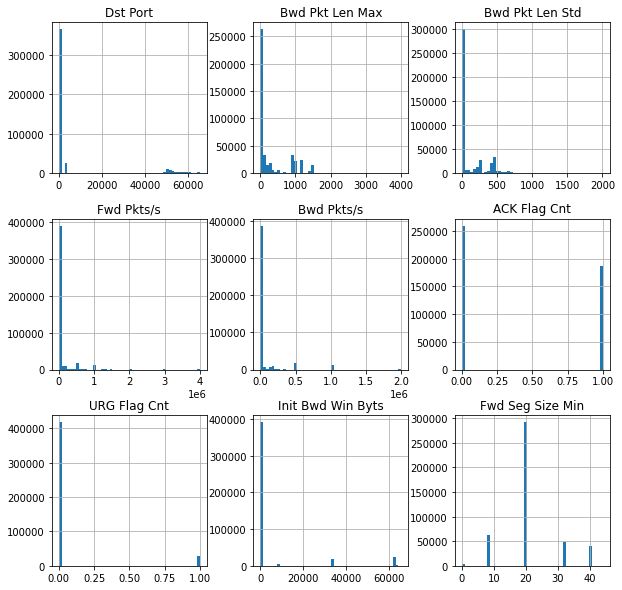

In [43]:
# Checking the data distribution in the second group with histograms
X_new.hist(bins = 50,figsize = (10,10))
plt.show()

In [45]:
DST = pd.cut(X_new['Dst Port'], bins=[-1,20000,40000,60000],
                  labels=["DstP[0, 20000]","DstP[20000, 40000]","DstP[40000, 60000]"])

BWDMAX = pd.cut(X_new['Bwd Pkt Len Max'],bins=[-1, 250, 500,750,1000, 5000],
                  labels=["BwdMax[0, 250]","BwdMax[250, 500]","BwdMax[500, 750]",
                          "BwdMax[750, 1000]", "BwdMax[1000, 5000]"])

BWDSTD = pd.cut(X_new['Bwd Pkt Len Std'],bins=[-1, 250, 500,750, 1000, 1500,2500],
                  labels=["BwdStd[0, 250]","BwdStd[250, 500]",
                          "BwdStd[500, 750]","BwdStd[750, 1000]", "BwdStd[1000, 1500]", "BwdStd[1500, 2000]"])

FWDPKS = pd.cut(X_new['Fwd Pkts/s'],bins=[0,1e6,2e6,3e6,4e6],
                  labels=["FwdPkts[0, 1]","Fwd Pkts[1, 2]","Fwd Pkts[2, 3]","Fwd Pkts[3, 4.5]"])


BWDPKS = pd.cut(X_new['Bwd Pkts/s'],bins=[0,0.5e6,1e6,1.5e6, 2.5e6],
                  labels=["Bwd Pkts[0.0, 0.5]","Bwd Pkts[0.5, 1.0]","Bwd Pkts[1.0, 1.5]","Bwd Pkts[1.5, 2]"])


ACKFLGCNT = X_new['ACK Flag Cnt'].replace({0: 'ACK[0]', 1: 'ACK[1]'})

URGFLGCNT = X_new['URG Flag Cnt'].replace({0: 'URG[0]', 1: 'URG[1]'})


INIT = pd.cut(X_new['Init Bwd Win Byts'],bins=[-2, 20000,40000,60000,80000],
                  labels=["InitBwd[-1, 20000]","InitBwd[20000, 40000]",
                          "InitBwd[40000, 60000]","InitBwd[60000, 80000]"])

FWDSEG = pd.cut(X_new['Fwd Seg Size Min'],bins=[-1,10,20,30,40, 50],
                  labels=["FwdMin[0, 10]","FwdMin[10, 20]","FwdMin[20, 30]","FwdMin[30, 40]", "FwdMin[40, 50]"])

In [46]:
cols  = [
    DST, BWDMAX, BWDSTD, FWDPKS, BWDPKS, ACKFLGCNT, URGFLGCNT, INIT, FWDSEG, X_new.Label.astype('category')
]

cats = pd.concat(cols,axis=1)



In [47]:
cats.head()

,Dst Port,Bwd Pkt Len Max,Bwd Pkt Len Std,Fwd Pkts/s,Bwd Pkts/s,ACK Flag Cnt,URG Flag Cnt,Init Bwd Win Byts,Fwd Seg Size Min,Label
0,"DstP[40000, 60000]","BwdMax[0, 250]","BwdStd[0, 250]","FwdPkts[0, 1]","Bwd Pkts[0.0, 0.5]",ACK[0],URG[0],"InitBwd[20000, 40000]","FwdMin[10, 20]",Benign
1,"DstP[0, 20000]","BwdMax[0, 250]","BwdStd[0, 250]","FwdPkts[0, 1]","Bwd Pkts[0.0, 0.5]",ACK[0],URG[0],"InitBwd[-1, 20000]","FwdMin[0, 10]",Benign
2,"DstP[40000, 60000]","BwdMax[0, 250]","BwdStd[0, 250]","FwdPkts[0, 1]","Bwd Pkts[0.0, 0.5]",ACK[1],URG[1],"InitBwd[-1, 20000]","FwdMin[10, 20]",Benign
3,"DstP[0, 20000]","BwdMax[0, 250]","BwdStd[0, 250]","FwdPkts[0, 1]",NaN,ACK[1],URG[0],"InitBwd[-1, 20000]","FwdMin[10, 20]",Benign
4,"DstP[0, 20000]","BwdMax[1000, 5000]","BwdStd[500, 750]","FwdPkts[0, 1]","Bwd Pkts[0.0, 0.5]",ACK[0],URG[0],"InitBwd[-1, 20000]","FwdMin[10, 20]",Benign


In [48]:
# drop those values
cats = cats.dropna()

# recheck
cats.isna().sum().sum()

0

### Analysis

We apply the association rules to the features selected at the previous step.

We will use [Efficient Apriori](https://pypi.org/project/efficient-apriori/) to generate association rules.

In [28]:
# import efficient_apriori for for association analysis
# install it with
# !pip install efficient-apriori

from efficient_apriori import apriori

In [49]:
# Put all elements into a single list
txns=cats.values.reshape(-1).tolist()

# Create a dataframe using this single list and add a column for count
df_list=pd.DataFrame(txns)
df_list['Count']=1

# Group by items and rename columns
df_list=df_list.groupby(by=[0], as_index=False).count().sort_values(by=['Count'], ascending=True) # count
df_list['Percentage'] = (df_list['Count'] / df_list['Count'].sum()) # percentage
df_list=df_list.rename(columns={0 : 'Item'})

# Show dataframe
df_list

,Item,Count,Percentage
13,"BwdStd[1500, 2000]",1,3.547118e-07
24,"FwdMin[40, 50]",2,7.094236e-07
6,"Bwd Pkts[1.5, 2]",59,2.092800e-05
18,"DstP[20000, 40000]",94,3.334291e-05
16,"BwdStd[750, 1000]",114,4.043715e-05
22,"FwdMin[20, 30]",173,6.136514e-05
28,"InitBwd[40000, 60000]",460,1.631674e-04
10,"BwdMax[500, 750]",3156,1.119470e-03
5,"Bwd Pkts[0.5, 1.0]",12762,4.526832e-03
27,"InitBwd[20000, 40000]",15112,5.360405e-03


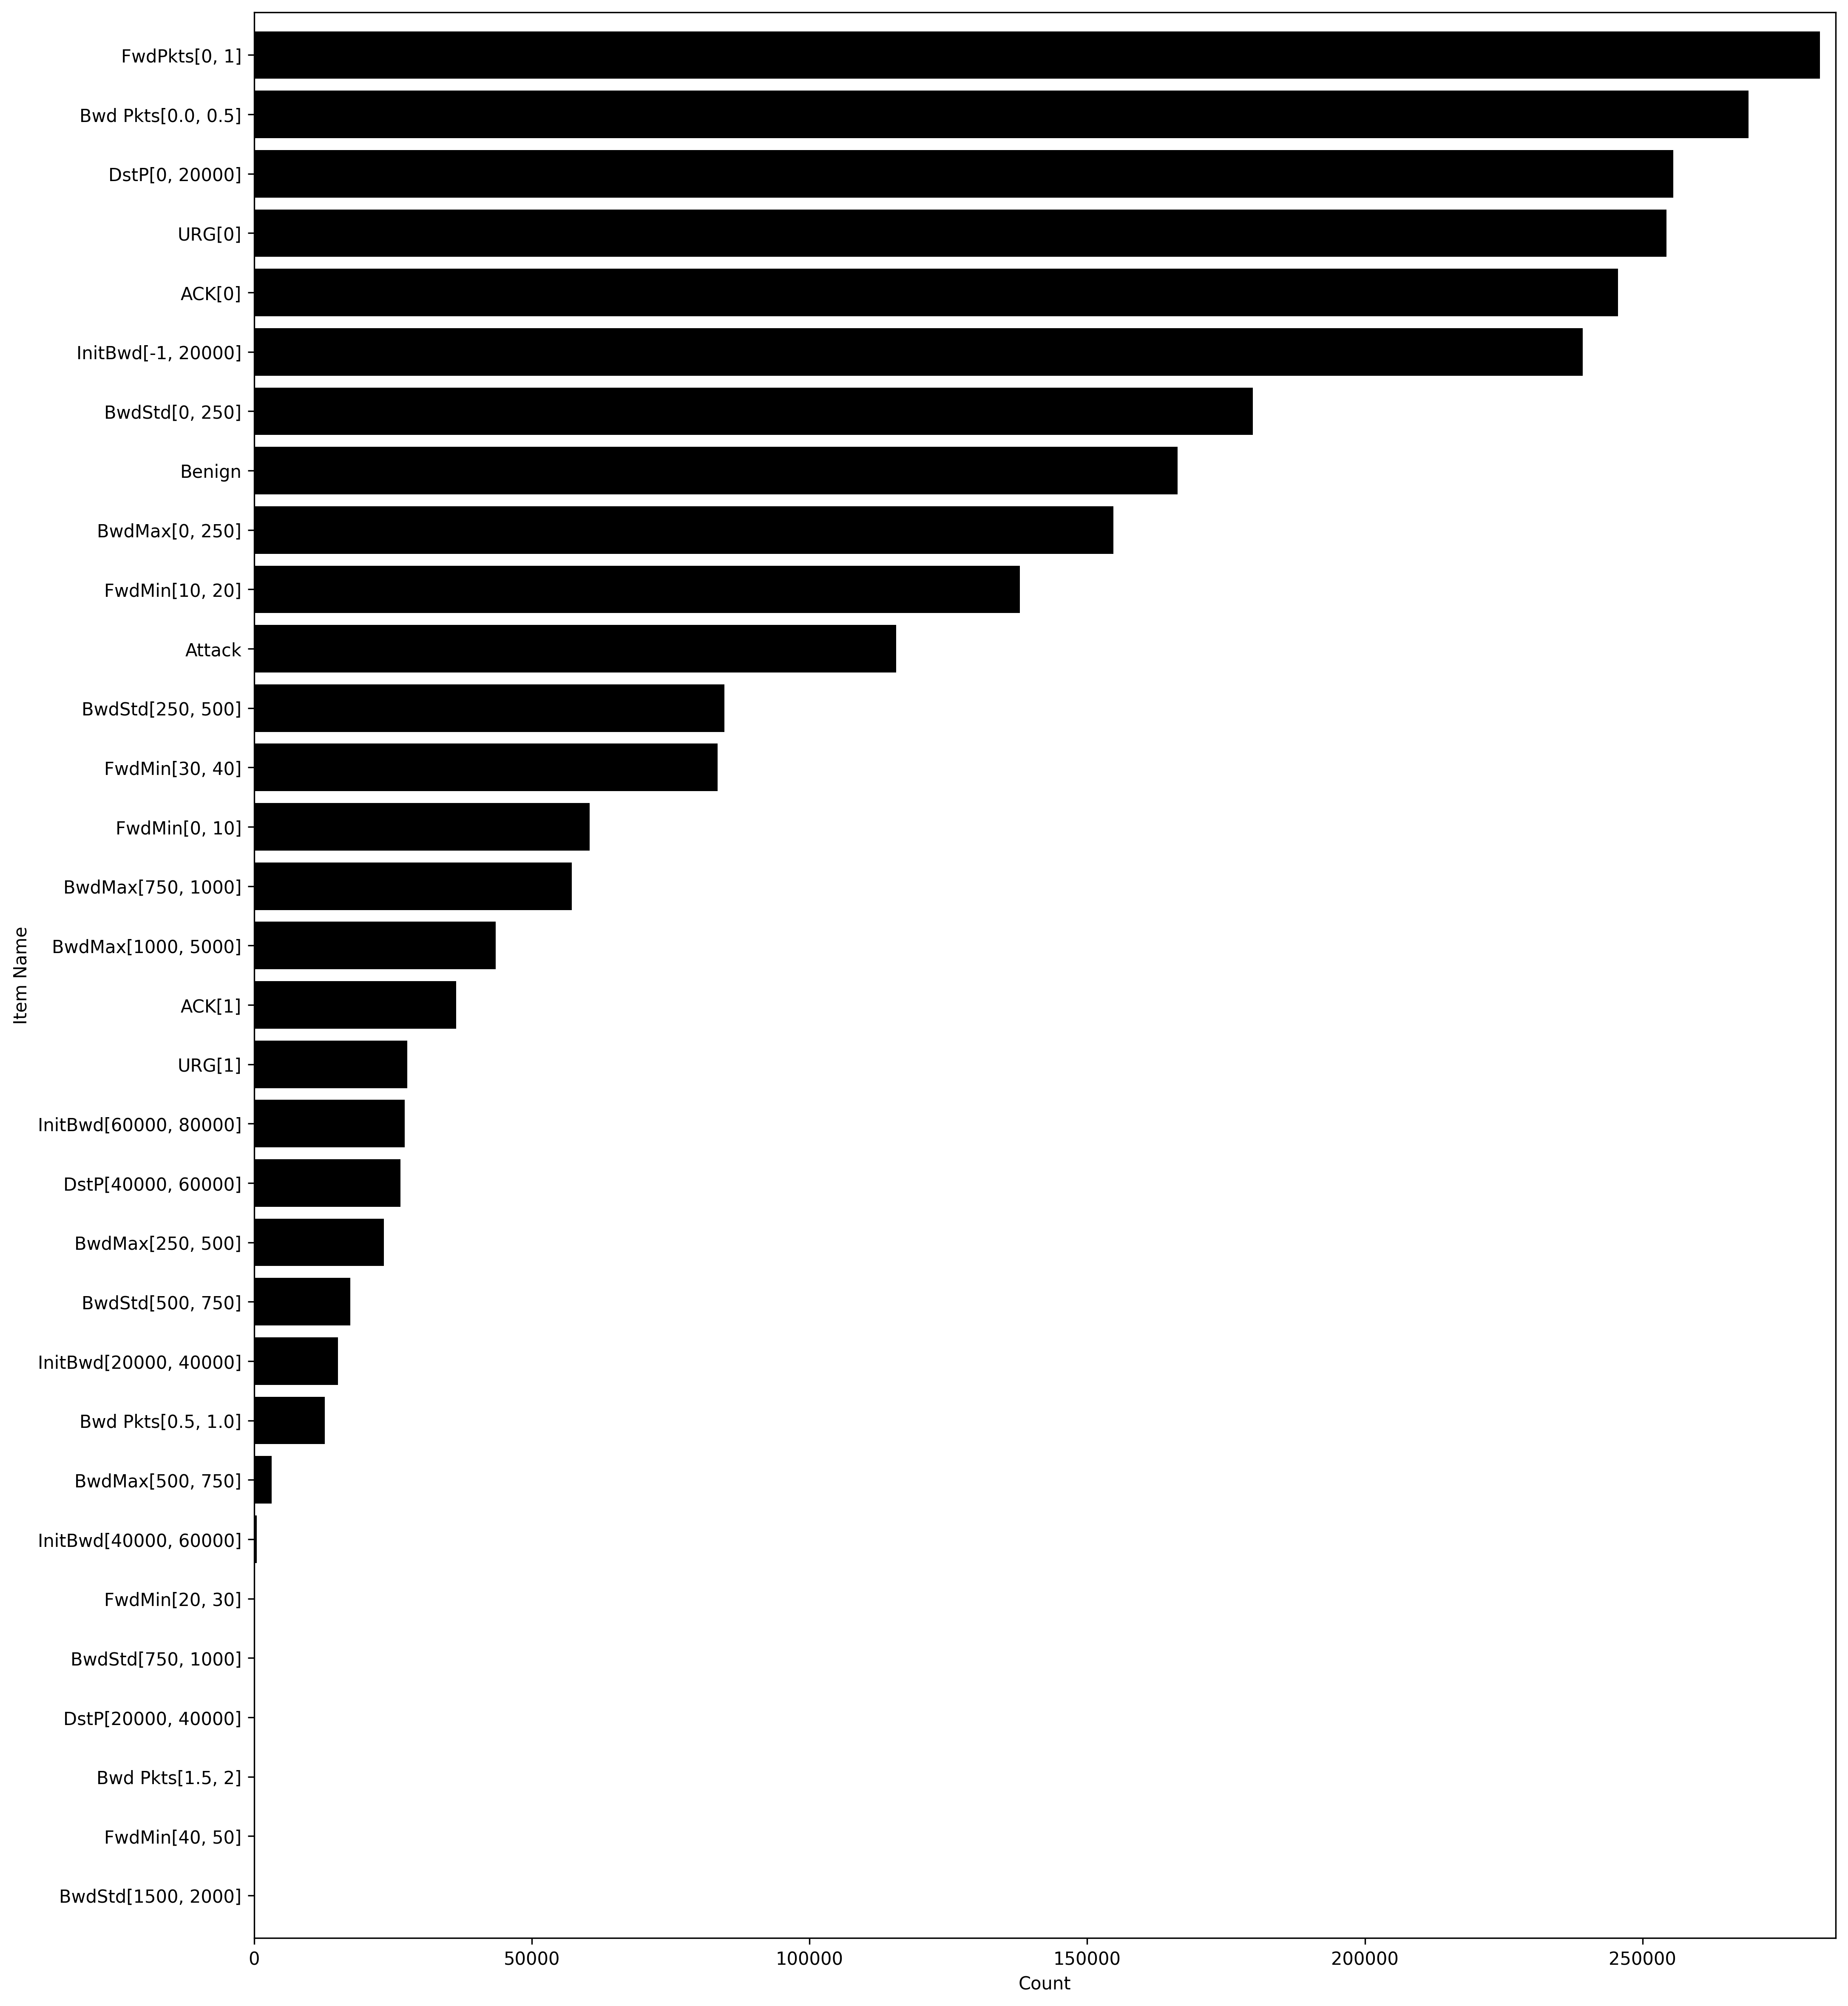

In [50]:
# Draw a horizontal bar chart
plt.figure(figsize=(16,20), dpi=300)
plt.ylabel('Item Name')
plt.xlabel('Count')
plt.barh(df_list['Item'], width=df_list['Count'], color='black', height=0.8)
plt.margins(0.01)   
plt.show()

In [51]:
# Create a list of lists from a dataframe
txns2=cats.stack().groupby(level=0).apply(list).tolist()

In [52]:
itemsets, rules = apriori(txns2, min_support=0.03, min_confidence=0.2, verbosity=1)

Generating itemsets.
 Counting itemsets of length 1.
  Found 32 candidate itemsets of length 1.
  Found 24 large itemsets of length 1.
 Counting itemsets of length 2.
  Found 276 candidate itemsets of length 2.
  Found 180 large itemsets of length 2.
 Counting itemsets of length 3.
  Found 694 candidate itemsets of length 3.
  Found 668 large itemsets of length 3.
 Counting itemsets of length 4.
  Found 1466 candidate itemsets of length 4.
  Found 1466 large itemsets of length 4.
 Counting itemsets of length 5.
  Found 2063 candidate itemsets of length 5.
  Found 2063 large itemsets of length 5.
 Counting itemsets of length 6.
  Found 1924 candidate itemsets of length 6.
  Found 1924 large itemsets of length 6.
 Counting itemsets of length 7.
  Found 1189 candidate itemsets of length 7.
  Found 1189 large itemsets of length 7.
 Counting itemsets of length 8.
  Found 470 candidate itemsets of length 8.
  Found 470 large itemsets of length 8.
Itemset generation terminated.

Generating ru

In [53]:
# we filter the rules that have at least 5 elements on the left hand side
# and one element (the class) on the right hand side
rules_rhs = filter(lambda rule: len(rule.lhs) >= 5 and len(rule.rhs) == 1, rules)

# create lists to append rules for the benign and attack classes
benign_rules, attack_rules = list(), list()
for rule in sorted(rules_rhs, key=lambda rule: rule.lift):
    k = rule.rhs[0]  
    if k == "Attack":
        attack_rules.append((rule.lhs, "-->" ,rule.rhs))
    elif k == "Benign":
        benign_rules.append((rule.lhs, "-->" ,rule.rhs))

In [54]:
attack_rules[:3]

[(('ACK[0]',
   'Bwd Pkts[0.0, 0.5]',
   'BwdStd[0, 250]',
   'FwdPkts[0, 1]',
   'URG[0]'),
  '-->',
  ('Attack',)),
 (('Bwd Pkts[0.0, 0.5]',
   'BwdStd[0, 250]',
   'FwdPkts[0, 1]',
   'InitBwd[-1, 20000]',
   'URG[0]'),
  '-->',
  ('Attack',)),
 (('Bwd Pkts[0.0, 0.5]',
   'BwdStd[0, 250]',
   'DstP[0, 20000]',
   'FwdPkts[0, 1]',
   'URG[0]'),
  '-->',
  ('Attack',))]

In [55]:
benign_rules[:3]

[(('ACK[1]',
   'Bwd Pkts[0.0, 0.5]',
   'BwdMax[0, 250]',
   'BwdStd[0, 250]',
   'URG[1]'),
  '-->',
  ('Benign',)),
 (('ACK[1]',
   'Bwd Pkts[0.0, 0.5]',
   'BwdMax[0, 250]',
   'FwdPkts[0, 1]',
   'URG[1]'),
  '-->',
  ('Benign',)),
 (('ACK[1]',
   'Bwd Pkts[0.0, 0.5]',
   'BwdStd[0, 250]',
   'FwdPkts[0, 1]',
   'URG[1]'),
  '-->',
  ('Benign',))]

## Predictive Model

We build the predictive model on the entire data set, without feature selection.

In [36]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

pipeline_xgb = make_pipeline(StandardScaler(), xgb)

scoring = {'f1': 'f1_macro', 'precision': 'precision_macro', 'accuracy': 'accuracy',
           'recall': 'recall_macro', 'roc_auc': 'roc_auc'}

pipeline_xgb

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, eval_metric='logloss',
                               gamma=None, gpu_id=None, importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               use_label_encoder=False,
                               validate_parameters=None, verbosity=None))])

In [37]:
pm_results = cross_validate(pipeline_xgb, X, y, cv=cv, scoring=scoring)

In [38]:
# rows 5 & 6 are the averages and standard deviations of each column
append_avgs(pm_results)

,fit_time,score_time,test_f1,test_precision,test_accuracy,test_recall,test_roc_auc
0,24.707968,0.400978,0.999944,0.999944,0.999944,0.999944,1.000000
1,26.079097,0.374879,0.999899,0.999899,0.999899,0.999899,0.999981
2,26.189501,0.379088,0.999944,0.999944,0.999944,0.999944,1.000000
3,29.419180,0.445254,0.999899,0.999899,0.999899,0.999899,1.000000
4,29.455176,0.498405,0.999933,0.999933,0.999933,0.999933,0.999998
5,27.170185,0.419721,0.999924,0.999924,0.999924,0.999924,0.999996
6,1.923221,0.046597,0.000021,0.000021,0.000021,0.000021,0.000007


## Anomaly Detection

In [39]:
# fit the XGB on the original data set
xgb.fit(X,y)

mae_before = mean_absolute_error(xgb.predict(X),y)
print("The MAE before IF is: ", mae_before)

The MAE before IF is:  2.238518637906179e-06


In [40]:
# define the Isolation Forest
iso = IsolationForest(contamination='auto',random_state=42)

# fit the data to IF
y_pred = iso.fit_predict(X, y)

# filter out predictions values = -1 
# as they are considered as anomalies
mask = y_pred != -1
X_if, y_if = X[mask], y[mask]

In [41]:
# fit the XGB on the new data set
xgb.fit(X_if, y_if)

# compute the MAE
mae_after = mean_absolute_error(xgb.predict(X),y)
print("The MAE after IF is: ", mae_after)

The MAE after IF is:  0.0005641066967523572


In [42]:
# compute the difference between the MAEs before and after IF

print(mae_before - mae_after)

-0.000561868178114451


The difference is a negative number, therefore applying the IF increased the MAE (decreased the performance) in this case.